# <h1><center>How I learned to stop worrying and love Random Forests: A step-by-step guide to the fast.ai way of doing Random Forests (Part 1)</center></h1>

In this notebook I'll show how a non-paramtric model like Random Forests can not only fit structured data incredibly well but can also be easily interpretable! To do this I'll review step-by-step the Random Forest model training workflow covered in the Fast.ai Machine Learning [course](https://course.fast.ai/ml) (which I highly recommend. No where else will you find such a practical view of learning and using machine learning). I'll be exploring the [Ames Housing dataset](http://www.amstat.org/publications/jse/v19n3/decock.pdf) which is the subject of the kaggle [Housing Prices competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

## Background

The bias-variance tradeoff is an oft quoted dilemma in machine learning. For those who haven't it goes something like this: 

-  Variance is the amount by which our estimation of the response (our model's predictions) changes with different training data. Ideally the estimate of the response should not vary too much between training sets. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (otherwise known as overfitting).
-  Bias is the error that is introduced by approximating a complex problem with a much simpler (and inflexible) model. High bias can cause an algorithm to miss the relevant relations between features and target outputs (otherwise known as underfitting).

The goal of machine learning is to simultaneously have low bias and low variance in our models.

When selecting a model type for machine learning we have two choices: parametric or non-paramtric. A parametrized model is where we assume an underlying functional form for the relationship between our features, $X$, and the response, $Y$. Fitting a parametric model simply boils down to estimating the parameters for the underlying function of our model. Parametric moddels generally have high bias but relatively low variance; they are seen as a relatively inflexible approach, but provide easy inference though and are seen as more 'intellectually pure'.

A non-parametric model assumes no functional form for our model and tries to estimate a form that fits the data as close as possible without being too rough or wiggly. Very flexible, good for prediction though always run the risk of overfitting. There is a general trade-off between prediction accuracy and model interpretability

As a general rule, as we use more flexible methods, the variance will increase and the bias will decrease. The relative rate of change of these two quantities determines whether the test error increases or decreases. As we increase the flexibility of a class of methods, the bias tends to initially decrease faster than the variance increases. Consequently, the expected test error declines. However, at some point increasing flexibility has little impact on the bias but starts to significantly increase the variance. When this happens the test error increases.

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [1]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "data/house-prices/"

In [82]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [72]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
display_all(df_raw.T)

0        1        2        3        4        5        6     \
Id                   1        2        3        4        5        6        7   
MSSubClass          60       20       60       70       60       50       20   
MSZoning            RL       RL       RL       RL       RL       RL       RL   
LotFrontage         65       80       68       60       84       85       75   
LotArea           8450     9600    11250     9550    14260    14115    10084   
Street            Pave     Pave     Pave     Pave     Pave     Pave     Pave   
Alley              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
LotShape           Reg      Reg      IR1      IR1      IR1      IR1      Reg   
LandContour        Lvl      Lvl      Lvl      Lvl      Lvl      Lvl      Lvl   
Utilities       AllPub   AllPub   AllPub   AllPub   AllPub   AllPub   AllPub   
LotConfig       Inside      FR2   Inside   Corner      FR2   Inside   Inside   
LandSlope          Gtl      Gtl      Gtl      Gtl      Gtl      Gtl      Gtl   
Neighborhood   CollgCr  Veenker  CollgCr  Crawfor  NoRidge  Mitchel  Somerst   
Condition1        Norm    Feedr     Norm     Norm     Norm     Norm     Norm   
Condition2        Norm     Norm     Norm     Norm     Norm     Norm     Norm   
BldgType          1Fam     1Fam     1Fam     1Fam     1Fam     1Fam     1Fam   
HouseStyle      2Story   1Story   2Story   2Story   2Story   1.5Fin   1Story   
OverallQual          7        6        7        7        8        5        8   
OverallCond          5        8        5        5        5        5        5   
YearBuilt         2003     1976     2001     1915     2000     1993     2004   
YearRemodAdd      2003     1976     2002     1970     2000     1995     2005   
RoofStyle        Gable    Gable    Gable    Gable    Gable    Gable    Gable   
RoofMatl       CompShg  CompShg  CompShg  CompShg  CompShg  CompShg  CompShg   
Exterior1st    VinylSd  MetalSd  VinylSd  Wd Sdng  VinylSd  VinylSd  VinylSd   
Exterior2nd    VinylSd  MetalSd  VinylSd  Wd Shng  VinylSd  VinylSd  VinylSd   
MasVnrType     BrkFace     None  BrkFace     None  BrkFace     None    Stone   
MasVnrArea         196        0      162        0      350        0      186   
ExterQual           Gd       TA       Gd       TA       Gd       TA       Gd   
ExterCond           TA       TA       TA       TA       TA       TA       TA   
Foundation       PConc   CBlock    PConc   BrkTil    PConc     Wood    PConc   
BsmtQual            Gd       Gd       Gd       TA       Gd       Gd       Ex   
BsmtCond            TA       TA       TA       Gd       TA       TA       TA   
BsmtExposure        No       Gd       Mn       No       Av       No       Av   
BsmtFinType1       GLQ      ALQ      GLQ      ALQ      GLQ      GLQ      GLQ   
BsmtFinSF1         706      978      486      216      655      732     1369   
BsmtFinType2       Unf      Unf      Unf      Unf      Unf      Unf      Unf   
BsmtFinSF2           0        0        0        0        0        0        0   
BsmtUnfSF          150      284      434      540      490       64      317   
TotalBsmtSF        856     1262      920      756     1145      796     1686   
Heating           GasA     GasA     GasA     GasA     GasA     GasA     GasA   
HeatingQC           Ex       Ex       Ex       Gd       Ex       Ex       Ex   
CentralAir           Y        Y        Y        Y        Y        Y        Y   
Electrical       SBrkr    SBrkr    SBrkr    SBrkr    SBrkr    SBrkr    SBrkr   
1stFlrSF           856     1262      920      961     1145      796     1694   
2ndFlrSF           854        0      866      756     1053      566        0   
LowQualFinSF         0        0        0        0        0        0        0   
GrLivArea         1710     1262     1786     1717     2198     1362     1694   
BsmtFullBath         1        0        1        1        1        1        1   
BsmtHalfBath         0        1        0        0        0        0        0   
FullBath          

In [9]:
display_all(df_raw.describe(include='all').T)

count unique      top  freq       mean       std    min     25%  \
Id             1460    NaN      NaN   NaN      730.5    421.61      1  365.75   
MSSubClass     1460    NaN      NaN   NaN    56.8973   42.3006     20      20   
MSZoning       1460      5       RL  1151        NaN       NaN    NaN     NaN   
LotFrontage    1201    NaN      NaN   NaN      70.05   24.2848     21      59   
LotArea        1460    NaN      NaN   NaN    10516.8   9981.26   1300  7553.5   
Street         1460      2     Pave  1454        NaN       NaN    NaN     NaN   
Alley            91      2     Grvl    50        NaN       NaN    NaN     NaN   
LotShape       1460      4      Reg   925        NaN       NaN    NaN     NaN   
LandContour    1460      4      Lvl  1311        NaN       NaN    NaN     NaN   
Utilities      1460      2   AllPub  1459        NaN       NaN    NaN     NaN   
LotConfig      1460      5   Inside  1052        NaN       NaN    NaN     NaN   
LandSlope      1460      3      Gtl  1382        NaN       NaN    NaN     NaN   
Neighborhood   1460     25    NAmes   225        NaN       NaN    NaN     NaN   
Condition1     1460      9     Norm  1260        NaN       NaN    NaN     NaN   
Condition2     1460      8     Norm  1445        NaN       NaN    NaN     NaN   
BldgType       1460      5     1Fam  1220        NaN       NaN    NaN     NaN   
HouseStyle     1460      8   1Story   726        NaN       NaN    NaN     NaN   
OverallQual    1460    NaN      NaN   NaN    6.09932     1.383      1       5   
OverallCond    1460    NaN      NaN   NaN    5.57534    1.1128      1       5   
YearBuilt      1460    NaN      NaN   NaN    1971.27   30.2029   1872    1954   
YearRemodAdd   1460    NaN      NaN   NaN    1984.87   20.6454   1950    1967   
RoofStyle      1460      6    Gable  1141        NaN       NaN    NaN     NaN   
RoofMatl       1460      8  CompShg  1434        NaN       NaN    NaN     NaN   
Exterior1st    1460     15  VinylSd   515        NaN       NaN    NaN     NaN   
Exterior2nd    1460     16  VinylSd   504        NaN       NaN    NaN     NaN   
MasVnrType     1452      4     None   864        NaN       NaN    NaN     NaN   
MasVnrArea     1452    NaN      NaN   NaN    103.685   181.066      0       0   
ExterQual      1460      4       TA   906        NaN       NaN    NaN     NaN   
ExterCond      1460      5       TA  1282        NaN       NaN    NaN     NaN   
Foundation     1460      6    PConc   647        NaN       NaN    NaN     NaN   
BsmtQual       1423      4       TA   649        NaN       NaN    NaN     NaN   
BsmtCond       1423      4       TA  1311        NaN       NaN    NaN     NaN   
BsmtExposure   1422      4       No   953        NaN       NaN    NaN     NaN   
BsmtFinType1   1423      6      Unf   430        NaN       NaN    NaN     NaN   
BsmtFinSF1     1460    NaN      NaN   NaN     443.64   456.098      0       0   
BsmtFinType2   1422      6      Unf  1256        NaN       NaN    NaN     NaN   
BsmtFinSF2     1460    NaN      NaN   NaN    46.5493   161.319      0       0   
BsmtUnfSF      1460    NaN      NaN   NaN     567.24   441.867      0     223   
TotalBsmtSF    1460    NaN      NaN   NaN    1057.43   438.705      0  795.75   
Heating        1460      6     GasA  1428        NaN       NaN    NaN     NaN   
HeatingQC      1460      5       Ex   741        NaN       NaN    NaN     NaN   
CentralAir     1460      2        Y  1365        NaN       NaN    NaN     NaN   
Electrical     1459      5    SBrkr  1334        NaN       NaN    NaN     NaN   
1stFlrSF       1460    NaN      NaN   NaN    1162.63   386.588    334     882   
2ndFlrSF       1460    NaN      NaN   NaN    346.992   436.528      0       0   
LowQualFinSF   1460    NaN      NaN   NaN    5.84452   48.6231      0       0   
GrLivArea      1460    NaN      NaN   NaN    1515.46    525.48    334  1129.5   
BsmtFullBath   1460    NaN      NaN   NaN   0.425342  0.518911      0       0   
BsmtHalfBath   1460    NaN      NaN   NaN  0.

It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [83]:
df_raw.SalePrice = np.log(df_raw.SalePrice)
df_raw.GrLivArea = np.log(df_raw.GrLivArea)

## Initial Processing

Before we can pass the dataset to the random forest we need to deal with two issues: 
1. Get rid of missing values 
2. Transform strings into something the forest can recognize (ints)

In [84]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/house-prices-raw')

For point 2. the categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [13]:
df_raw.LotConfig.dtype

dtype('O')

In [85]:
train_cats(df_raw)

Before we used `train_cats`, we can see that the feature `LotConfig` was treated as a pandas Object ('O'). This is pandas most general datatype, and hence is slow and not useful. We can turn each of the strings into a `CategoricalDtype` with specific categories to make the data faster to access and ready to be turned into an `int`.

In [15]:
df_raw.LotConfig.dtype

CategoricalDtype(categories=['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], ordered=True)

By using the prod_df function from the fastai lib, we'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

 **ASSUMPTION #1** Might need to return here and make sure all catgorical features have correct 'order' (i.e. would want high>medium>low). First run through doesn't look as though there are any clear orders but this might change

In [86]:
df, y, nas = proc_df(df_raw, 'SalePrice')

**ASSUMPTION #2** It looks like both the training and test set have 1460 entries. Hence we won't be able to have a validation set that is exactly like our test set in form. Let's try just spliting them in half for the time being. 

In [8]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 730
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((730, 83), (730,), (730, 83))

## Random Forests

### Base Model

In [28]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [14]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 122 ms
[0.0674886561883825, 0.16050651187668158, 0.9737271770878262, 0.8229040152934082]


An r^2 in the low-80's is ok (and the RMSLE puts us around rank 2900 of 3999 on the Kaggle leaderboard, better than the sample submission rank of 3788), but we can see from the validation set score that we're over-fitting badly. Let's look into how many trees our forest REALLY needs.

## Bagging

We'll grab the predictions for each individual tree, and look at one example.

In [15]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([12.87902, 12.47801, 12.52431, 12.40738, 12.36734, 12.87902, 12.52416, 12.47801, 12.79918, 12.52453]),
 12.58609401697524,
 12.373703486914124)

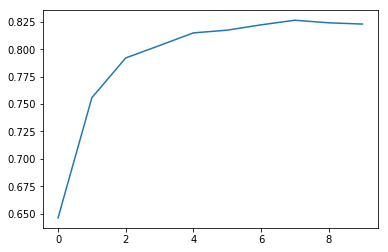

In [51]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Looks like our predictions level out after 7 trees. Let's double check:

In [52]:
mean1 = np.array([])
for j in [40,60]:
    for i in range(10):
        m = RandomForestRegressor(n_estimators = j, n_jobs=-1)
        m.fit(X_train, y_train) 
        _,_,_,x = print_score(m)
        mean1 = np.append(mean1,x)
    print(j, np.mean(mean1))

[0.06078329813378017, 0.14808315902614078, 0.9786885156246768, 0.8492578371922459]
[0.06213490549850165, 0.14589252607586442, 0.9777301925807435, 0.8536847852664445]
[0.06302084391573325, 0.14706985539698428, 0.977090605744397, 0.8513137761791155]
[0.06027380459364819, 0.14954243569422046, 0.9790442895658233, 0.8462722392965614]
[0.06082009789933832, 0.1486788260223704, 0.9786627027761602, 0.8480426723200848]
[0.061113176306752955, 0.14622019787877566, 0.9784565680143026, 0.8530268048826786]
[0.06047037052529823, 0.1465435860715457, 0.9789073844694971, 0.8523759788560876]
[0.06185057620139629, 0.1468201766952419, 0.9779335395117341, 0.8518181932254656]
[0.06091708696853102, 0.14452055879267559, 0.9785945958588975, 0.8564237304223032]
[0.06177429029468868, 0.14959291137501463, 0.9779879390639937, 0.8461684450405316]
40 0.850838446268152
[0.060685356810043035, 0.14571348958363445, 0.9787571395204159, 0.8540436753349449]
[0.05897937860285067, 0.1449348853358894, 0.9799347043906005, 0.8555

Turns out 40 trees is a touch better and 60 trees doesn't really add much. So let's go with 40 trees.

In [53]:
m = RandomForestRegressor(n_estimators = 40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.059744300976425024, 0.1448840502664744, 0.9794108629051286, 0.8557005892769667]


[0.059744300976425024,
 0.1448840502664744,
 0.9794108629051286,
 0.8557005892769667]

## Out-of-bag (OOB) Score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [54]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.06338487870078498, 0.14699885287917344, 0.9768251728168189, 0.8514573072629579, 0.8463285582096834]


[0.06338487870078498,
 0.14699885287917344,
 0.9768251728168189,
 0.8514573072629579,
 0.8463285582096834]

Since our OOB score is similar to the validation set score, we can see that we are indeed overfititng our model.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [57]:
set_rf_samples(550)

In [58]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0761398583191239, 0.1478502137216824, 0.9665597661502742, 0.8497317203846535, 0.8462671636950128]


[0.0761398583191239,
 0.1478502137216824,
 0.9665597661502742,
 0.8497317203846535,
 0.8462671636950128]

This doesn't seem to help as much as it did in  the fastai ML1 course, and this is likely due to the fact that we have such a small amount of data in this competition compared to the Bulldozer one (1460 vs 400k). Let's reset the samples and try limiting the minimum size of each leaf.

In [60]:
reset_rf_samples()

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [63]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf = 2, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07165163355765716, 0.1457630727605496, 0.970385979720592, 0.853944326817759, 0.8486229872011994]


[0.07165163355765716,
 0.1457630727605496,
 0.970385979720592,
 0.853944326817759,
 0.8486229872011994]

In [67]:
mean1 = np.array([])
for j in [2,3,5,10]:
    for i in range(10):
        m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = j,n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train) 
        _,_,_,x,_ = print_score(m)
        mean1 = np.append(mean1,x)
    print(j, np.mean(mean1))

[0.07643867126338157, 0.15028797691881882, 0.9662967768926763, 0.8447356042073116, 0.8451319891529633]
[0.07423679207323304, 0.1500757796764915, 0.968210509249015, 0.8451737419475143, 0.8410564955891954]
[0.07125352275831892, 0.1476433983002825, 0.9707141483287273, 0.8501518220633878, 0.8430375862646077]
[0.07420392994013983, 0.14950225985430468, 0.9682386472982653, 0.8463548287266397, 0.8468855838506207]
[0.07562331991287108, 0.14496726987319872, 0.9670119491268498, 0.8555347740755376, 0.8459573023078613]
[0.071687640554977, 0.14751991486140112, 0.9703562084558764, 0.85040237211308, 0.8443676581846999]
[0.07216587539251824, 0.1481732413128234, 0.9699593762896418, 0.8490743817732884, 0.846756364986289]
[0.07108951766326037, 0.14814583199605705, 0.9708488083737794, 0.8491302135203511, 0.8412377611899386]
[0.0727516181963191, 0.14729525422351622, 0.9694697407275275, 0.8508576748009058, 0.8490842246999957]
[0.07386934453913648, 0.1486589294666671, 0.9685244253328013, 0.8480833401840226, 0

Looks like we start to lose information after cutting off at 3, so lets stick with that.

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

In [65]:
mean1 = np.array([])
for j in [None,0.5,'log2','sqrt']:
    for i in range(10):
        m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = j,n_jobs=-1,oob_score=True)
        m.fit(X_train, y_train) 
        _,_,_,x,_ = print_score(m)
        mean1 = np.append(mean1,x)
    print(j, np.mean(mean1))

[0.08629596205331087, 0.14673354463634367, 0.9570437732052489, 0.8519930126262112]
[0.08526393739403948, 0.14931101276600306, 0.9580650678029383, 0.8467476709106188]
[0.08536557715712673, 0.1482144128894658, 0.9579650302691914, 0.8489904974106866]
[0.08540786380060128, 0.14467121012964865, 0.9579233751174834, 0.8561242404270206]
[0.08474377140447349, 0.14832322063672573, 0.9585751682973778, 0.8487686966469464]
[0.08342298736843955, 0.1464327718833762, 0.9598563689226445, 0.8525991568379488]
[0.08414412145782846, 0.14776669366836437, 0.9591593413153787, 0.8499014444529198]
[0.08292075848254406, 0.1445954250021376, 0.9603382649453241, 0.8562749378169432]
[0.08435782404655212, 0.14715693412853, 0.9589516301321095, 0.8511376525165848]
[0.0842426810018441, 0.145163164780802, 0.9590636104658777, 0.8551440772918071]
None 0.8517681386937689
[0.08663876990493713, 0.14271045847972663, 0.9567018109578527, 0.8599977537335022]
[0.08580602113182943, 0.14073902742073532, 0.957530152150599, 0.86383907

Looks like 0.5 works the best so lets go with that.

That's all there is to notebook #1 from the ML1 course. We're now at 2320 on the leaderboard, almost in the top 50%! But it looks like we're still heavily overfitting our training data. One bit might be trying to vary the validation set size. Let's try that before we move on to interpreting our results.

In [117]:
n_valid = 1
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1459, 83), (1459,), (1, 83))

In [118]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf = 3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07836851268932105, 0.02672034952550817, 0.9615069525119146, 0.0, 0.8719304610791863]


[0.07836851268932105,
 0.02672034952550817,
 0.9615069525119146,
 0.0,
 0.8719304610791863]

Since this is such a small dataset, we might just want to use the OOB score moving forward as including all of the data in the training set does push our OOB score up to 87.2%! But it seems like a 50/50 split with the train and valid still might be the way to go. Don't see much improvement between using half the dataset for training and the whole dataset. 

Now the above process worked fine but lets optimize our workflow with the use of parfit! parfit is a hyperparameter optimization package meant to complement sklearn's own `GridSearchCV`. Why use parfit over sklearn's in-house function? Cross-validation using GridSearchCV optimizes on the training data! As mentioned in Rachel Thomas’ [post](http://www.fast.ai/2017/11/13/validation-sets/), this is dangerous and not applicable to most real-world modeling problems (especially time series data). Instead, we want to optimize our hyper-parameters on the validation set.

In [23]:
from parfit import bestFit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1289s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.2s finished


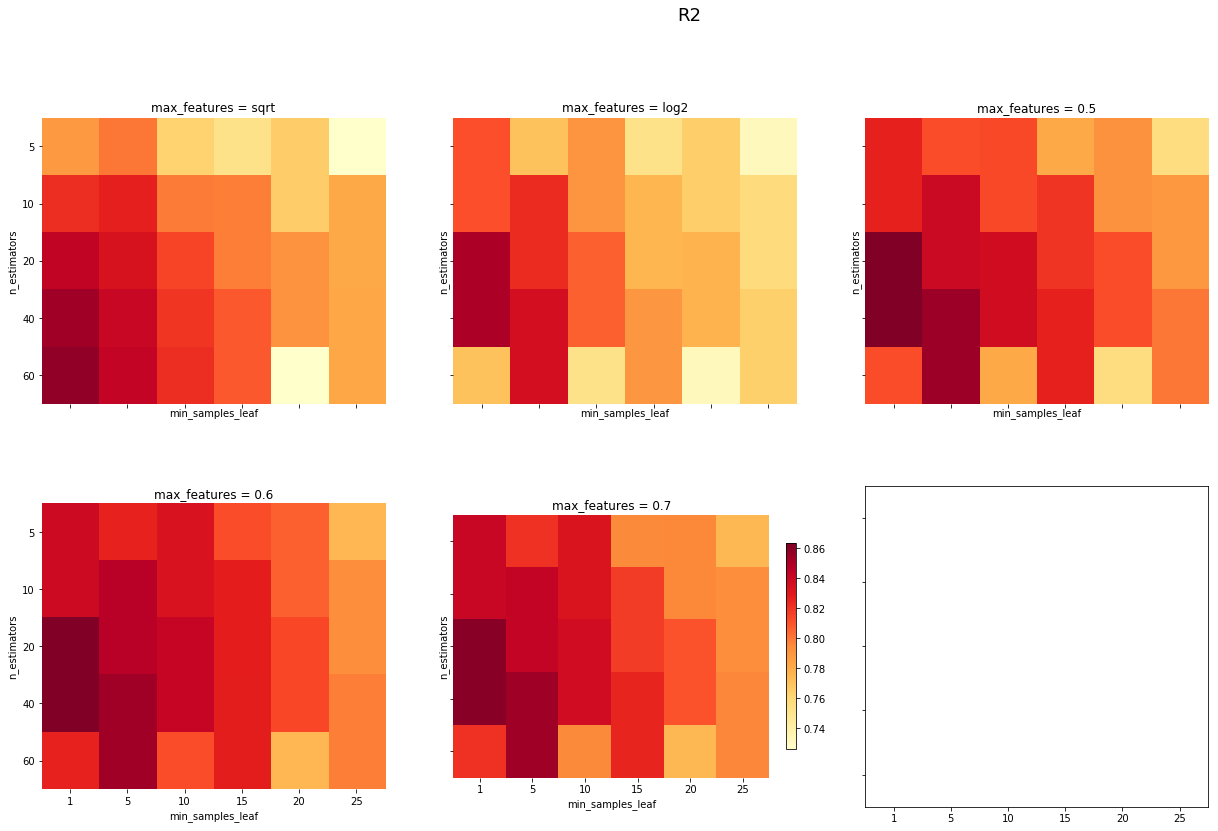

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 0.8632511992772915


In [25]:
grid = {
    'min_samples_leaf': [1, 5, 10, 15, 20, 25],
    'max_features': ['sqrt', 'log2', 0.5, 0.6, 0.7],
    'n_estimators': [5,10,20,40,60],
    'n_jobs': [-1],
    'random_state': [42]
}
paramGrid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = bestFit(RandomForestRegressor(), paramGrid,
                                                    X_train, y_train, X_valid, y_valid, # nfolds=5 [optional, instead of validation set]
                                                    metric=r2_score, greater_is_better=True, 
                                                    scoreLabel='R2')

print(best_model, best_score)

Cool! So it looks like with a 50/50 split with the validation and training data, it reccommends the above model. Pretty close to what we had found but nice that it did it automatically.

Let's move forward with some more exploratory data analysis (EDA) and interpreting what our ramdom forest is producing.

## Feature Importance

We can gain a better understanding of the features in our model by looking at each individual feature's importance. We can do this by randomizing the data for one feature at a time and seeing how randomizing that individual feature affects the accuracy of our already trained Random Forest model. 

For example:

We take our housing data set and we have a column ```Price``` we are trying to predict (dependent variable).
We have 79 independent variables and one of them is ```OverallQual```.
How do we figure out how important ```OverallQual``` is? We have a whole random forest and we can find out our predictive accuracy. So we will put all these rows through our random forest, and it will spit out some predictions. We will then compare them to the actual price (in this case, we get our root mean squared error and $R^2$). This is our starting point.

Let’s do exactly the same thing, but this time, take the ```OverallQual``` column and randomly shuffle it (i.e. randomly permute just that column). Now ```OverallQual``` has exactly the same distribution as before (same mean, same standard deviation). But it has no relationships with our dependent variable at all because we totally randomly reordered it.

Before, we might have found our r² was .89. After we shuffle ```OverallQual```, we check again, and now r² is .52. The score got much worse when we destroyed that variable.

Okay, let’s try again. We put ```OverallQual``` back to how it was, and this time let’s take ```GrLivArea``` and shuffle that. This time, $R^2$ is .73 and we can say the amount of decrease in our score for ```OverallQual``` was .37 and the amount of decrease for ```GrLivArea``` was .16. And this is going to give us our feature importances for each column.

In [88]:
??rf_feat_importance

In [87]:
fi = rf_feat_importance(m, df); fi[:10]

cols       imp
17   OverallQual  0.368787
46     GrLivArea  0.157587
19     YearBuilt  0.071442
62    GarageArea  0.043432
38   TotalBsmtSF  0.041441
61    GarageCars  0.037355
43      1stFlrSF  0.029089
27     ExterQual  0.024814
20  YearRemodAdd  0.019673
49      FullBath  0.015176

Ok so rather unexpectedly, the most important feature is the Overall Quality of the House.

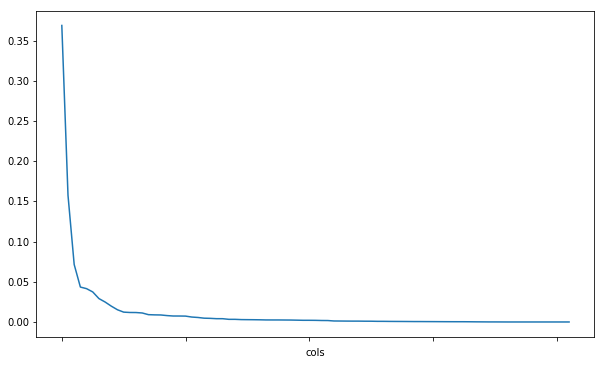

In [83]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [27]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

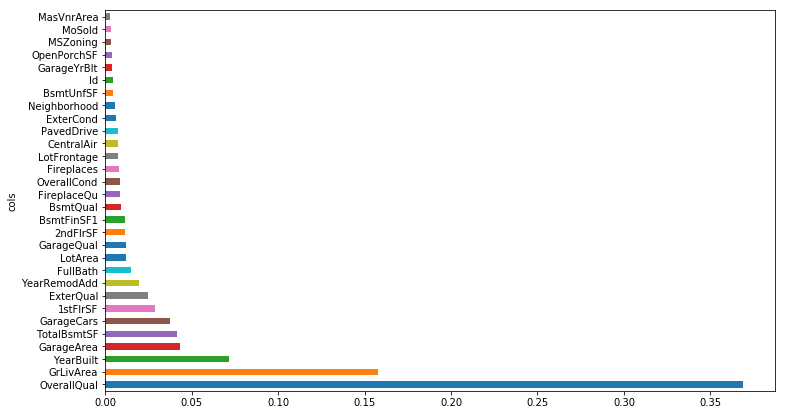

In [86]:
plot_fi(fi[:30]);

Let's remove the unimportant features of our data and see if that helps things.

In [96]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [125]:
df_keep = df[to_keep].copy()
n_trn = len(df)-730
X_train, X_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [126]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09188471011366682, 0.1413076968995768, 0.9512996955548244, 0.8627365098853159, 0.8535087492166215]


[0.09188471011366682,
 0.1413076968995768,
 0.9512996955548244,
 0.8627365098853159,
 0.8535087492166215]

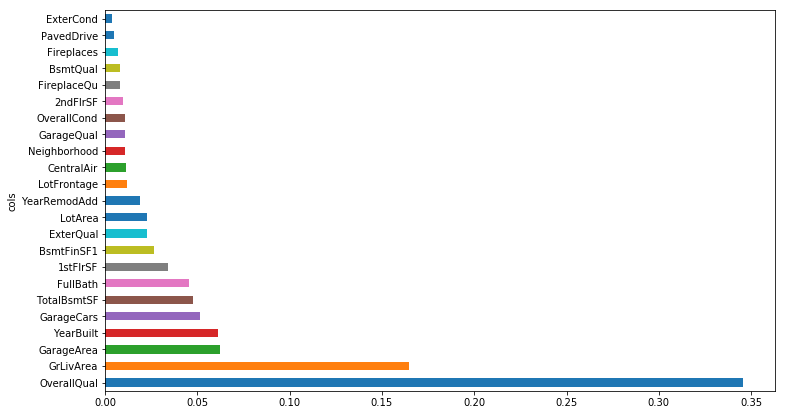

In [127]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In the above plot we see the benefit of removing all the unimportant features. Now that the model is unburdened by a bunch of useless information, we see that `OverallQual` is not the sole predictor and `GrLivArea` and `YearBuilt` now have more importance. 

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [87]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0602183375316198, 0.14035561713475747, 0.9790828408691752, 0.8645799414552325, 0.8455428032223401]


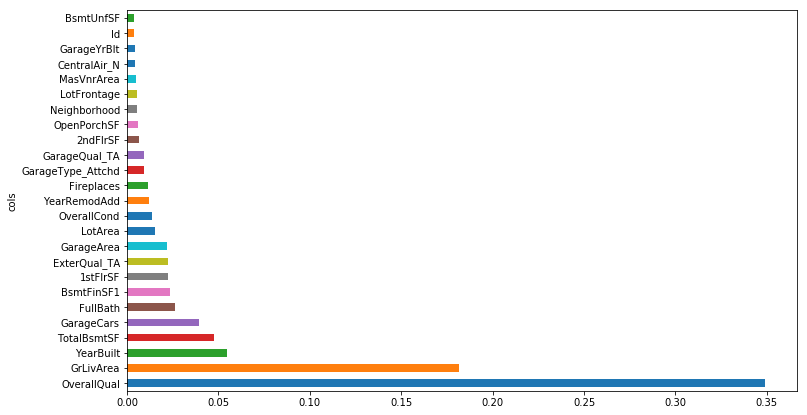

In [88]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

So by using one-hot encoding we see a few new features at the top of the list and the ordering has changed slightly. `GarageArea` is no longer the 4th in terms of importance and we see new features like `ExterQual_TA`. More specifically, it looks like only the `TA` category of `ExterQual` and `GarageQual`, the `Fa` category of `ExterCond`, the `Ex` category of `BsmtQual`, the `N` category of `PavedDrive` and the `Y` category of `CentralAir` matters in their respective features.

In [89]:
to_keep2 = fi[fi.imp>0.005].cols; len(to_keep2)

20

In [94]:
df_keep2 = df_trn2[to_keep2].copy()
X_train, X_valid = split_vals(df_keep2, n_trn)
m2 = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=0.6,
                          n_jobs=-1, oob_score=True)
m2.fit(X_train, y_train)
print_score(m2)

[0.05760854659268134, 0.1397712393626707, 0.9808566026347679, 0.8657052505714764, 0.8566857347554159]


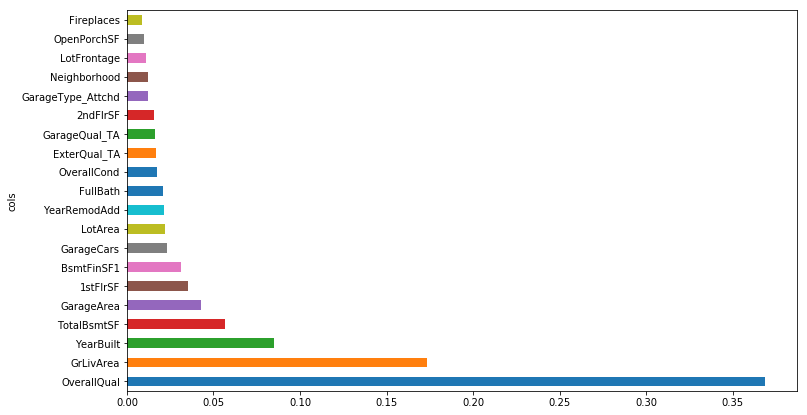

In [95]:
fi2 = rf_feat_importance(m2, df_keep2)
plot_fi(fi2[:20]);

Not clear whether our trimmed one-hot encoding model is better than just the regular trimmed model but they at least have different orderings of the features. Will be useful to continue to test both versions until a winner really sticks out.

## Removing Redundant features with unsupervised learning

One thing that makes this harder to interpret is if there are some variables with very similar meanings. Let's try to remove redundent features using some **unsupervised learning**; specifically we'll be using some **hierarchical (or agglomerated) clustering**.

In [39]:
from scipy.cluster import hierarchy as hc

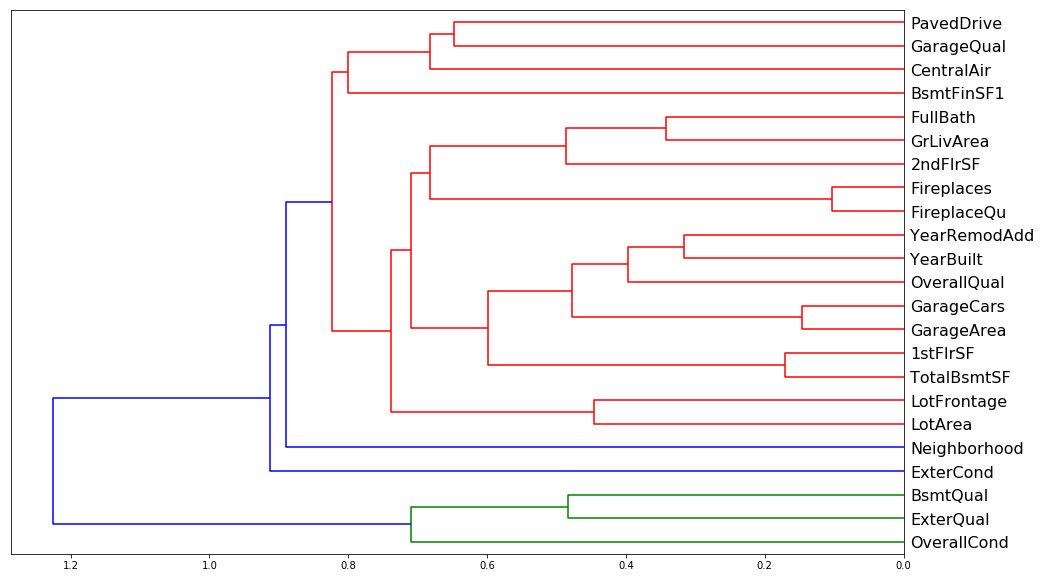

In [110]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

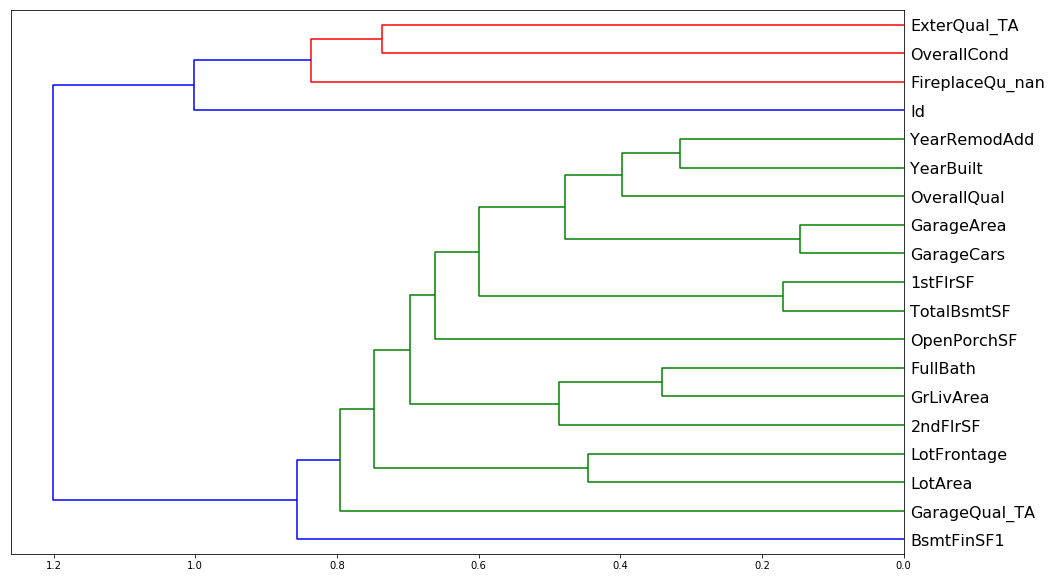

In [40]:
corr = np.round(scipy.stats.spearmanr(df_keep2).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep2.columns, orientation='left', leaf_font_size=16)
plt.show()

Doesn't look like there's much redundancy in the features of either one, though one worrisome aspect of both is the big blue split that occurs in both. There seems to be two major groupings in both sets of data which leads me to believe that some of these features are inextricably linked. Intuitively this would make sense, e.g. `GarageArea` and `GarageCars` must explain the same sort of aspect of the data, namely how big the garage is.

In [137]:
display_all(df_keep.describe(include='all').T)

count          mean          std     min      25%     50%  \
OverallQual   1460.0      6.099315     1.382997     1.0     5.00     6.0   
GrLivArea     1460.0   1515.463699   525.480383   334.0  1129.50  1464.0   
YearBuilt     1460.0   1971.267808    30.202904  1872.0  1954.00  1973.0   
GarageArea    1460.0    472.980137   213.804841     0.0   334.50   480.0   
TotalBsmtSF   1460.0   1057.429452   438.705324     0.0   795.75   991.5   
GarageCars    1460.0      1.767123     0.747315     0.0     1.00     2.0   
1stFlrSF      1460.0   1162.626712   386.587738   334.0   882.00  1087.0   
ExterQual     1460.0      3.539726     0.693995     1.0     3.00     4.0   
YearRemodAdd  1460.0   1984.865753    20.645407  1950.0  1967.00  1994.0   
FullBath      1460.0      1.565068     0.550916     0.0     1.00     2.0   
LotArea       1460.0  10516.828082  9981.264932  1300.0  7553.50  9478.5   
GarageQual    1460.0      4.594521     1.262078     0.0     5.00     5.0   
2ndFlrSF      1460.0    346.992466   436.528436     0.0     0.00     0.0   
BsmtFinSF1    1460.0    443.639726   456.098091     0.0     0.00   383.5   
BsmtQual      1460.0      3.178767     0.998402     0.0     3.00     3.0   
FireplaceQu   1460.0      1.969178     2.037956     0.0     0.00     2.0   
OverallCond   1460.0      5.575342     1.112799     1.0     5.00     5.0   
Fireplaces    1460.0      0.613014     0.644666     0.0     0.00     1.0   
LotFrontage   1460.0     69.863699    22.027677    21.0    60.00    69.0   
CentralAir    1460.0      1.934932     0.246731     1.0     2.00     2.0   
PavedDrive    1460.0      2.856164     0.496592     1.0     3.00     3.0   
ExterCond     1460.0      4.733562     0.731807     1.0     5.00     5.0   
Neighborhood  1460.0     13.251370     6.013735     1.0     8.00    13.0   

                   75%       max  
OverallQual       7.00      10.0  
GrLivArea      1776.75    5642.0  
YearBuilt      2000.00    2010.0  
GarageArea      576.00    1418.0  
TotalBsmtSF    1298.25    6110.0  
GarageCars        2.00       4.0  
1stFlrSF       1391.25    4692.0  
ExterQual         4.00       4.0  
YearRemodAdd   2004.00    2010.0  
FullBath          2.00       3.0  
LotArea       11601.50  215245.0  
GarageQual        5.00       5.0  
2ndFlrSF        728.00    2065.0  
BsmtFinSF1      712.25    5644.0  
BsmtQual          4.00       4.0  
FireplaceQu       3.00       5.0  
OverallCond       6.00       9.0  
Fireplaces        1.00       3.0  
LotFrontage      79.00     313.0  
CentralAir        2.00       2.0  
PavedDrive        3.00       3.0  
ExterCond         5.00       5.0  
Neighborhood     18.00      25.0

In [21]:
display_all(df_keep2.describe(include='all').T)

count          mean          std     min      25%     50%  \
OverallQual    1460.0      6.099315     1.382997     1.0     5.00     6.0   
GrLivArea      1460.0   1515.463699   525.480383   334.0  1129.50  1464.0   
YearBuilt      1460.0   1971.267808    30.202904  1872.0  1954.00  1973.0   
TotalBsmtSF    1460.0   1057.429452   438.705324     0.0   795.75   991.5   
GarageArea     1460.0    472.980137   213.804841     0.0   334.50   480.0   
ExterQual_TA   1460.0      0.620548     0.485417     0.0     0.00     1.0   
1stFlrSF       1460.0   1162.626712   386.587738   334.0   882.00  1087.0   
GarageCars     1460.0      1.767123     0.747315     0.0     1.00     2.0   
LotArea        1460.0  10516.828082  9981.264932  1300.0  7553.50  9478.5   
BsmtFinSF1     1460.0    443.639726   456.098091     0.0     0.00   383.5   
GarageYrBlt    1460.0   1978.589041    23.997022  1900.0  1962.00  1980.0   
YearRemodAdd   1460.0   1984.865753    20.645407  1950.0  1967.00  1994.0   
2ndFlrSF       1460.0    346.992466   436.528436     0.0     0.00     0.0   
GarageQual_TA  1460.0      0.897945     0.302824     0.0     1.00     1.0   
OverallCond    1460.0      5.575342     1.112799     1.0     5.00     5.0   
LotFrontage    1460.0     69.863699    22.027677    21.0    60.00    69.0   
Fireplaces     1460.0      0.613014     0.644666     0.0     0.00     1.0   
Neighborhood   1460.0     13.251370     6.013735     1.0     8.00    13.0   
ExterCond_Fa   1460.0      0.019178     0.137198     0.0     0.00     0.0   
BsmtUnfSF      1460.0    567.240411   441.866955     0.0   223.00   477.5   
FullBath       1460.0      1.565068     0.550916     0.0     1.00     2.0   

                    75%       max  
OverallQual        7.00      10.0  
GrLivArea       1776.75    5642.0  
YearBuilt       2000.00    2010.0  
TotalBsmtSF     1298.25    6110.0  
GarageArea       576.00    1418.0  
ExterQual_TA       1.00       1.0  
1stFlrSF        1391.25    4692.0  
GarageCars         2.00       4.0  
LotArea        11601.50  215245.0  
BsmtFinSF1       712.25    5644.0  
GarageYrBlt     2001.00    2010.0  
YearRemodAdd    2004.00    2010.0  
2ndFlrSF         728.00    2065.0  
GarageQual_TA      1.00       1.0  
OverallCond        6.00       9.0  
LotFrontage       79.00     313.0  
Fireplaces         1.00       3.0  
Neighborhood      18.00      25.0  
ExterCond_Fa       0.00       1.0  
BsmtUnfSF        808.00    2336.0  
FullBath           2.00       3.0

Let's look at the partial dependence to see if we can find any interactions between the features.

## Partial Dependence Plots

In [96]:
df_keep2.to_feather('tmp/house-prices-ohe-trim')

In [97]:
fi2[:10]

cols       imp
0    OverallQual  0.368414
1      GrLivArea  0.173185
2      YearBuilt  0.085010
3    TotalBsmtSF  0.056902
9     GarageArea  0.042945
7       1stFlrSF  0.035206
6     BsmtFinSF1  0.031514
4     GarageCars  0.023275
10       LotArea  0.022124
12  YearRemodAdd  0.021555

In [78]:
df_raw = pd.read_feather('tmp/house-prices-raw')

In [98]:
x_all = get_sample(df_raw, 500)

ggplot is the main way Jeremy reccommends looking at univariate relationships. By adding standard error equals true (se=True), it also shows me the confidence interval of this smoother. loess stands for locally weighted regression which is this idea of doing lots of little mini regressions.

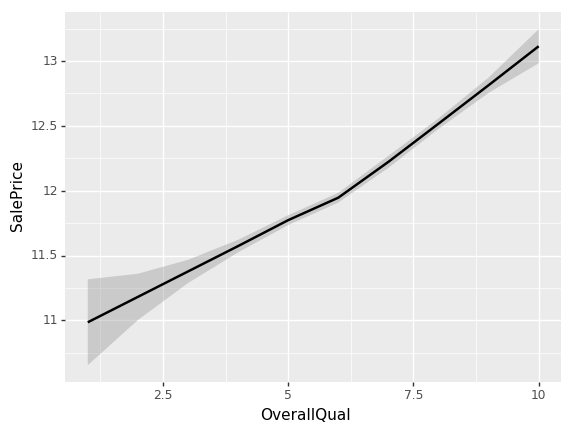

<ggplot: (-9223363268887317700)>

In [30]:
ggplot(x_all, aes('OverallQual', 'SalePrice'))+stat_smooth(se=True, method='loess')

Looks like something occurs at an OverallQual of 6. The slope of the log of the sale price shifts to a higher value.

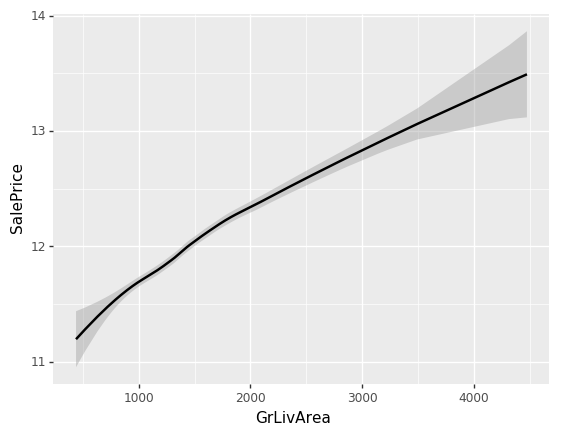

<ggplot: (8767966078335)>

In [31]:
ggplot(x_all, aes('GrLivArea', 'SalePrice'))+stat_smooth(se=True, method='loess')

Looks like it starts to level off after 2000. I wonder how this would do with log GrLivArea

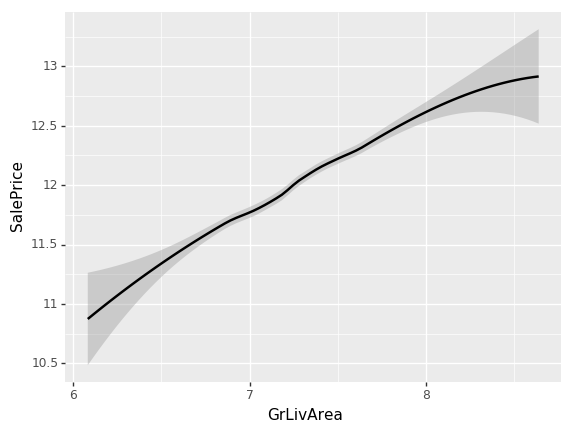

<ggplot: (8746504262043)>

In [99]:
ggplot(x_all, aes('GrLivArea', 'SalePrice'))+stat_smooth(se=True, method='loess')

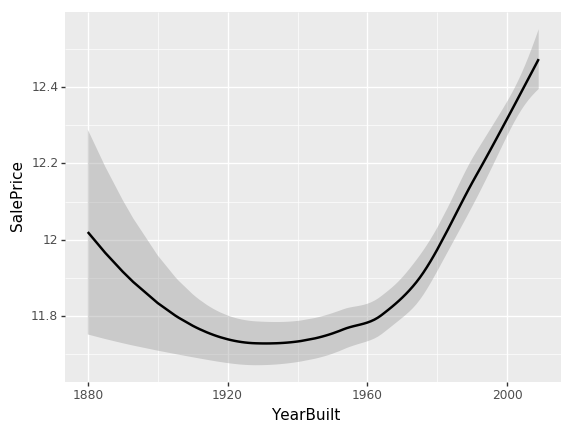

<ggplot: (8767967175088)>

In [32]:
ggplot(x_all, aes('YearBuilt', 'SalePrice'))+stat_smooth(se=True, method='loess')

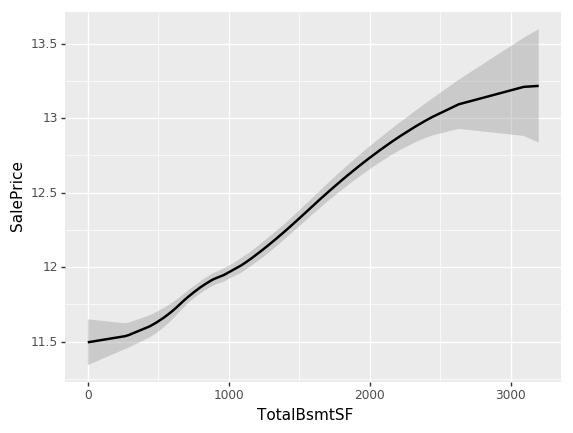

<ggplot: (-9223363268887702966)>

In [34]:
ggplot(x_all, aes('TotalBsmtSF', 'SalePrice'))+stat_smooth(se=True, method='loess')

Univariate plots are interesting but they do not tell the whole story. For example, what we really want to know is the relationship between `SalePrice` and `OverallQual` all other things being equal. We can look at this by viewing some partial dependence plots. 

In [48]:
from pdpbox import pdp
from plotnine import *

In [103]:
x = get_sample(df_keep2, 500)

In [64]:
def plot_pdp(feat, model_feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m2, x, model_feat,feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

In [104]:
model_feat = x.columns.values.tolist()

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f474ce7dfd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f474c6336a0>})

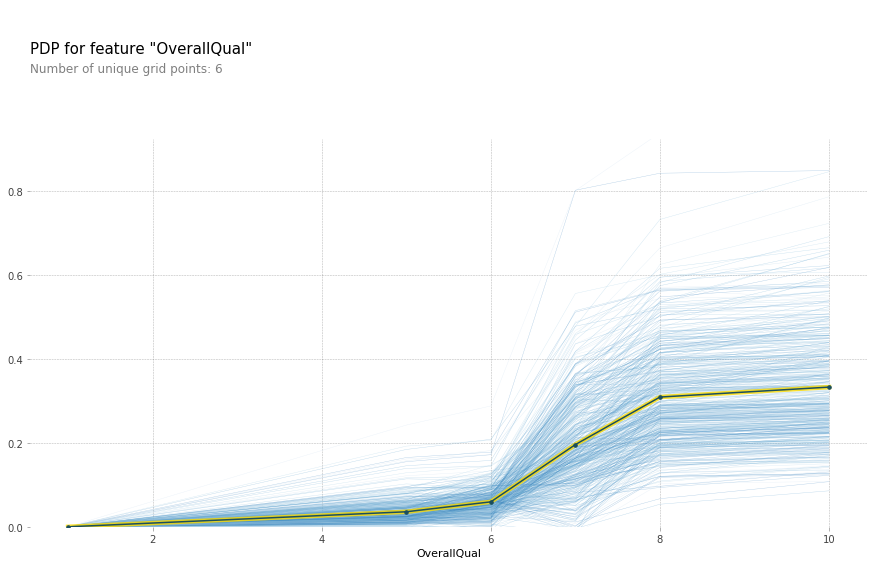

In [51]:
plot_pdp('OverallQual',model_feat)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f474c8ec6d8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f474c88a160>})

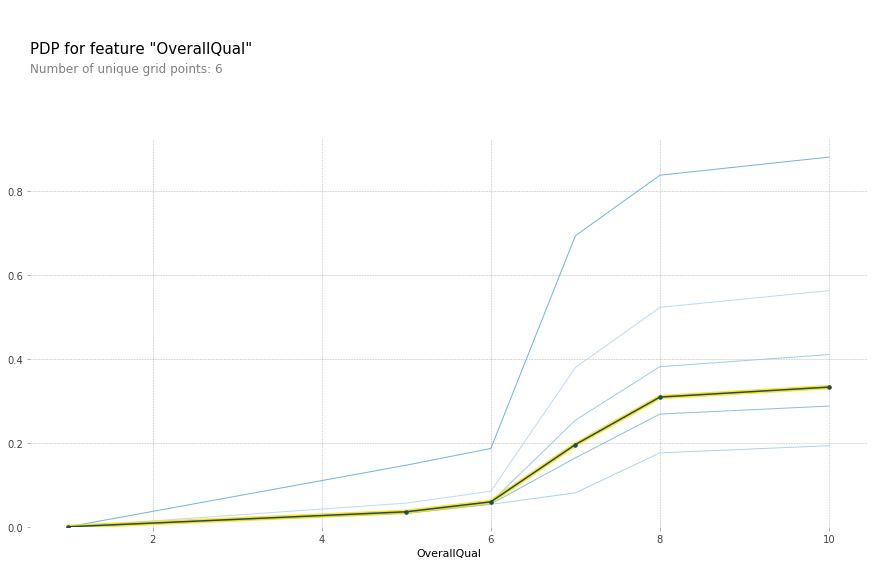

In [53]:
plot_pdp('OverallQual',model_feat,clusters = 5)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f474c83f9e8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f474c7f1748>})

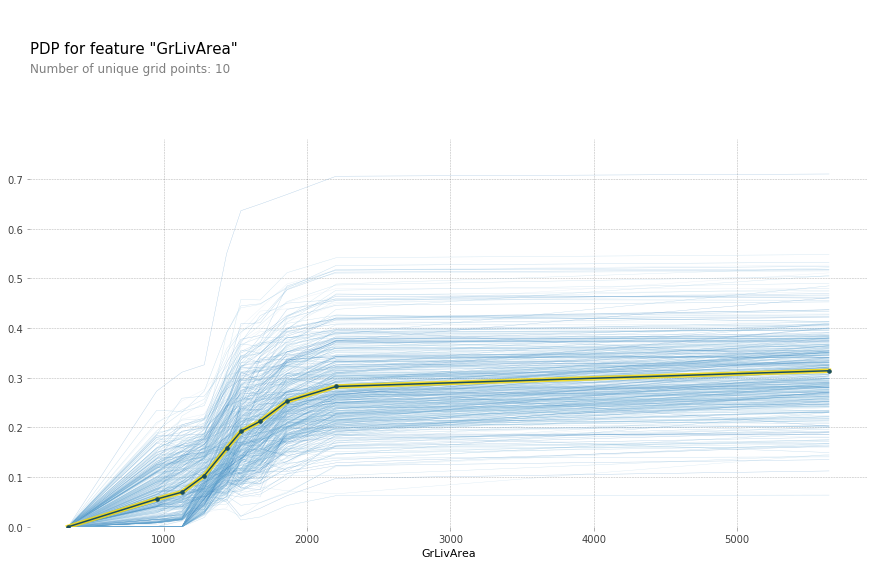

In [54]:
plot_pdp('GrLivArea',model_feat)

The above plot makes it seem like `GrLivArea` should definitely be in log. After rerunning the feature importance, `GrLivArea` jumped from ~0.15 to ~0.24! Definitely seems like a good move. Now lets see the new plot:

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f474473bba8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4744707b00>})

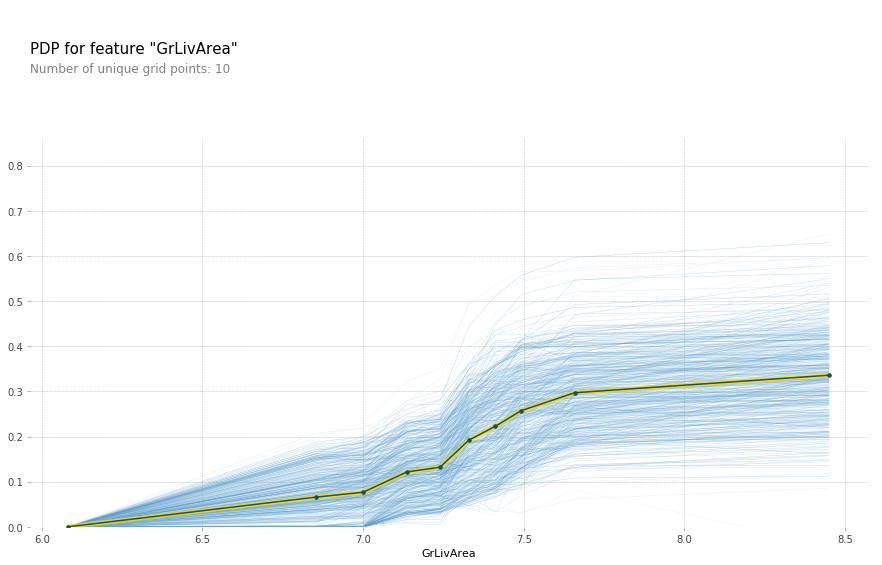

In [105]:
plot_pdp('GrLivArea',model_feat)

Remember, back at the univariate plots this was basically a straight line. Something happens at roughly

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f47446a77b8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4746a282b0>})

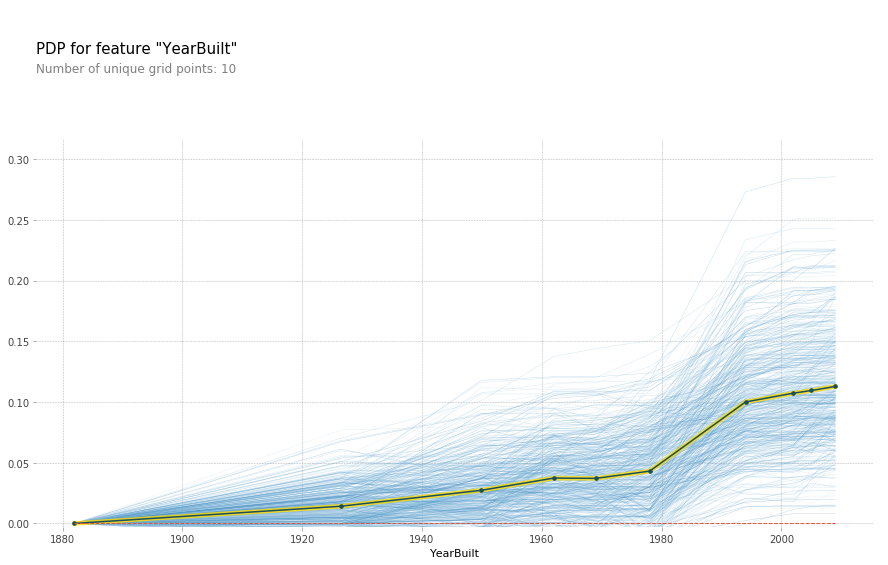

In [106]:
plot_pdp('YearBuilt',model_feat)

This plot is **extremely** different than the univariate plot. Something must be up with those old houses. Need to check. Maybe they're all really really big? That or just the fact that they are old is what fetches them such a high price.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f474415ac88>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f47441afc18>})

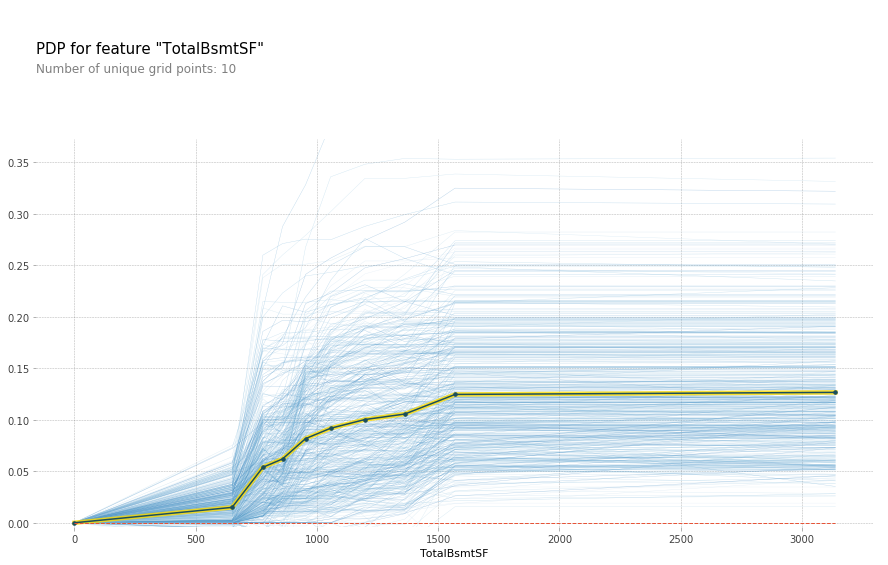

In [107]:
plot_pdp('TotalBsmtSF',model_feat)

Another one that could benefit from taking the log of the variable. In fact it looks like a number of the SF and Area variables can benefit from it.

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)